In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from utils import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

### This notebook use the MLP regressor as the final estimator of the stack regression. 

Open the dataset with the cases aggregated by uf and epiweek

In [3]:
data = pd.read_csv('../data/dengue_uf.csv.gz')

data.head()

,uf,date,casos
0,AC,2010-01-03,869
1,AC,2010-01-10,1003
2,AC,2010-01-17,1010
3,AC,2010-01-24,1397
4,AC,2010-01-31,2000


Class that create a custom regression model to be used in the stacking based on the predictions sent to mosqlimate api.

In [4]:
df_preds_all = pd.read_csv('../predictions/preds_models.csv.gz', index_col = 'Unnamed: 0')
df_preds_all = df_preds_all.rename(columns = {'adm_1': 'state'})
df_preds_all.head()

,date,pred,lower,upper,state,model_id
0,2022-10-09,110.690113,64.291013,219.826948,AC,21
1,2022-10-16,144.952846,77.564037,279.722708,AC,21
2,2022-10-23,163.613937,92.915072,276.591399,AC,21
3,2022-10-30,170.240443,87.197631,378.407811,AC,21
4,2022-11-06,215.117888,111.835667,445.024983,AC,21


The cell below get the models available for each state:

In [5]:
models_by_state = df_preds_all.groupby('state')['model_id'].agg(lambda x: list(set(x))).reset_index()
models_by_state

,state,model_id
0,AC,"[34, 21, 22, 27, 28, 30]"
1,AL,"[34, 21, 22, 27, 28, 30]"
2,AM,"[34, 21, 22, 27, 28, 30]"
3,AP,"[34, 21, 22, 27, 28, 30]"
4,BA,"[34, 21, 22, 27, 28, 30]"
5,CE,"[34, 21, 22, 25, 27, 28, 30]"
6,DF,"[34, 21, 22, 27, 28, 30]"
7,ES,"[34, 21, 22, 30]"
8,GO,"[34, 21, 22, 25, 27, 28, 30]"
9,MA,"[34, 21, 22, 27, 28, 30]"


### Applying the stacking using the `pred` column only (mean = True)

In the cell below, the stacking regressor will be applied using MLP as the final estimator. The stack model is trained using the predictions for 2023 and tested using the predictions for 2024. The performance of the train and test are shown in the figure. 

The worst performance in 2024 is expected since the models that performed better in 2023 performed worse in 2024. 

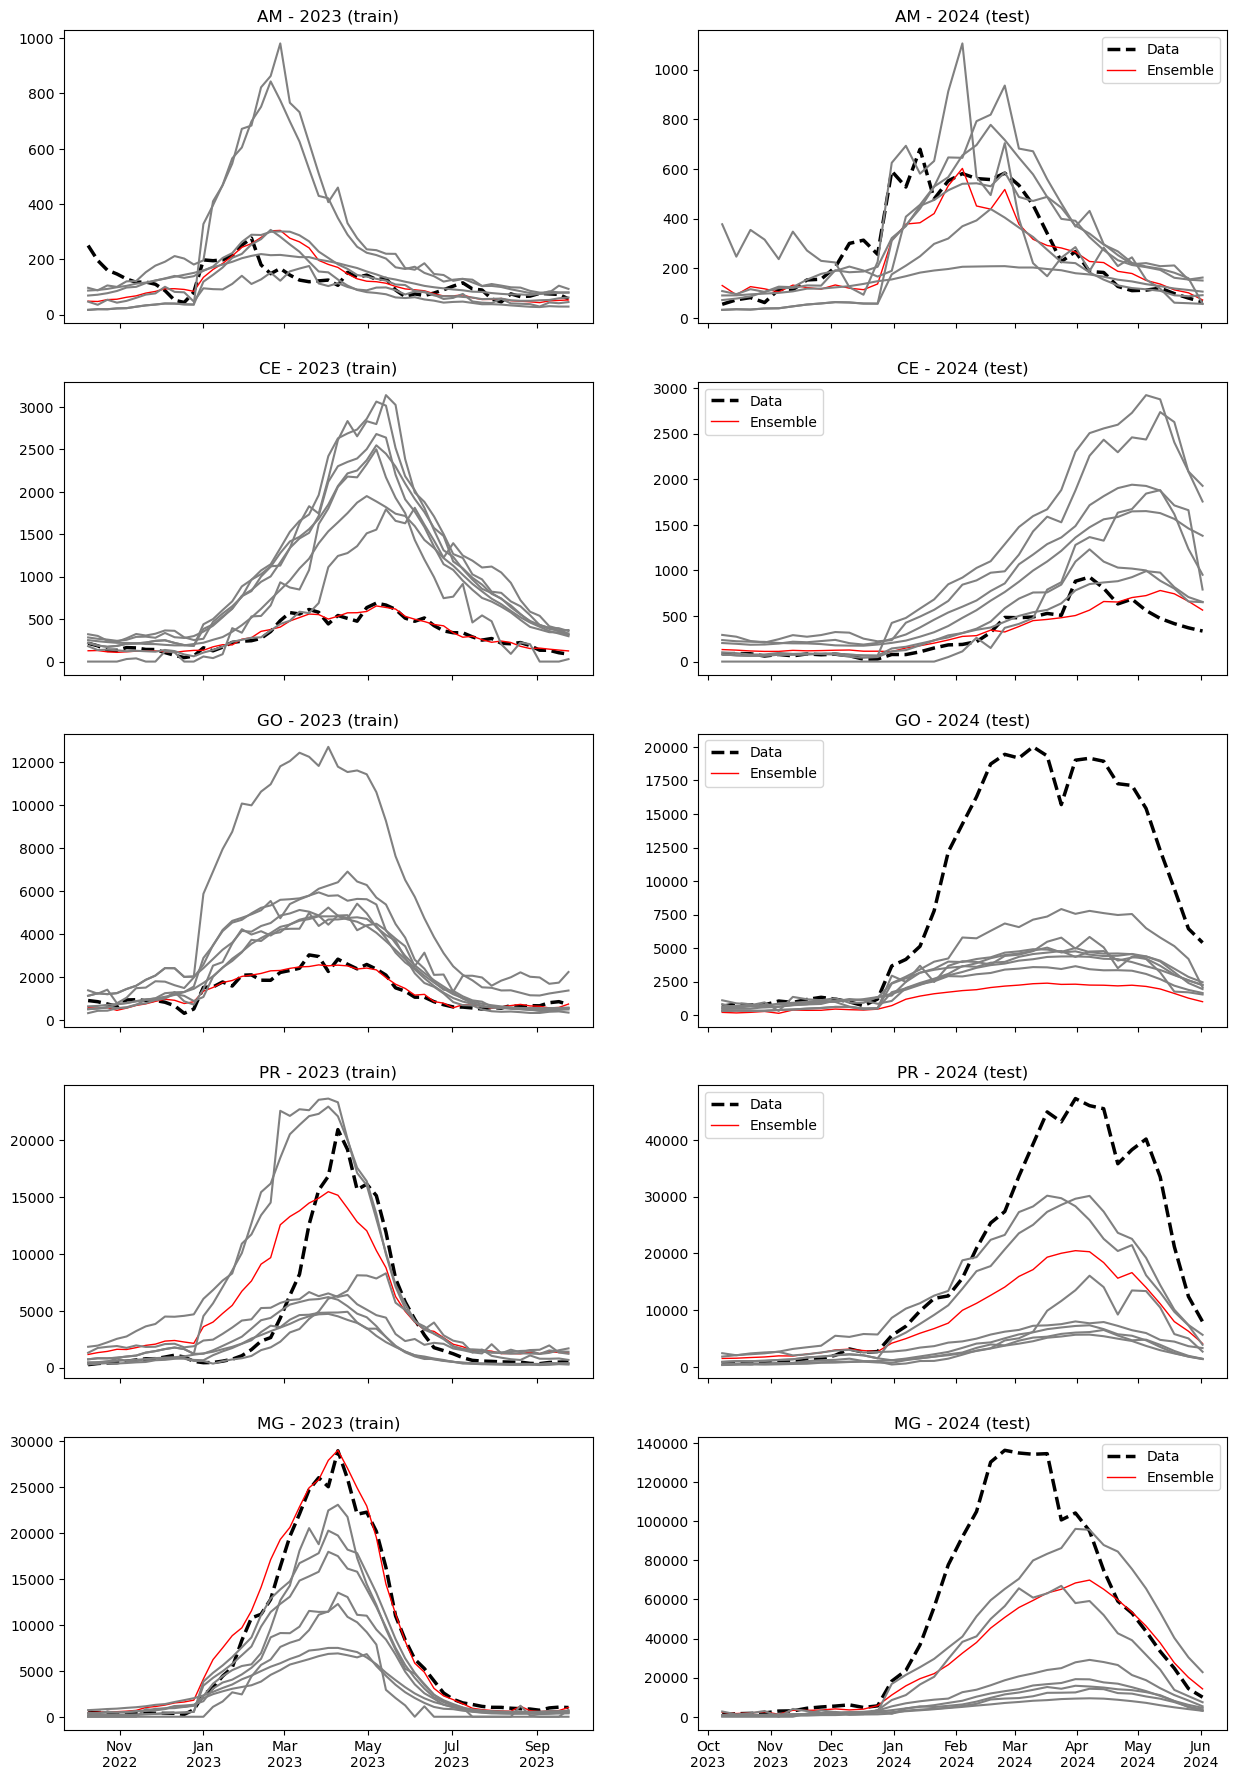

In [6]:
fig, axs  = plt.subplots(5,2, figsize = (15, 25))

ax = axs.ravel()

i = 0
for state in ['AM', 'CE', 'GO', 'PR', 'MG']: 

    X, y = get_data_slice(data, state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))
    
    
    estimators = []
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
    
         estimators.append((f'{model_id}', SprintModel(model_id = model_id,
                                                      state = state)))
    
        
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=MLPRegressor()
    )
    
    stack.fit(X.values, y)
    
    stack_preds = stack.predict(X.values)

    dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    ax[i].plot(dates_23, y, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)
    
    ax[i].plot(dates_23, stack_preds, color = 'red', label = 'Ensemble', linewidth = 1)
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
    
        ax[i].plot(dates_23, SprintModel(model_id = model_id, state = state).predict(X.values),
               color = 'grey')

    ax[i].set_title(f'{state} - 2023 (train)')

    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'
            
    X, y = get_data_slice(data, state, start_date = Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                          end_date = '2024-06-02')

    stack_preds = stack.predict(X.values)
    
    dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                  end= '2024-06-02',
                  freq='W-SUN')

    ax[i+1].plot(dates_24, y, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)

    ax[i+1].plot(dates_24, stack_preds, color = 'red', label = 'Ensemble', linewidth = 1)
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
        
        ax[i+1].plot(dates_24, SprintModel(model_id = model_id, state = state).predict(X.values),
               color = 'grey')
    
    ax[i+1].legend()
    
    ax[i+1].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'
            
    ax[i+1].set_title(f'{state} - 2024 (test)')
    
    i = i+2

# Rotate the date labels for better readability
fig.autofmt_xdate(rotation=0, ha='center')

plt.show()


In [14]:
estimators[0][1]

SprintModel(mean=False, model_id=34, state='MG')

In the cell below, the stacking regressor will be applied using MLP as the final estimator. The stack model is trained using the predictions from 2023 and 2024. The Figure represents the in-sample performance in each state. 

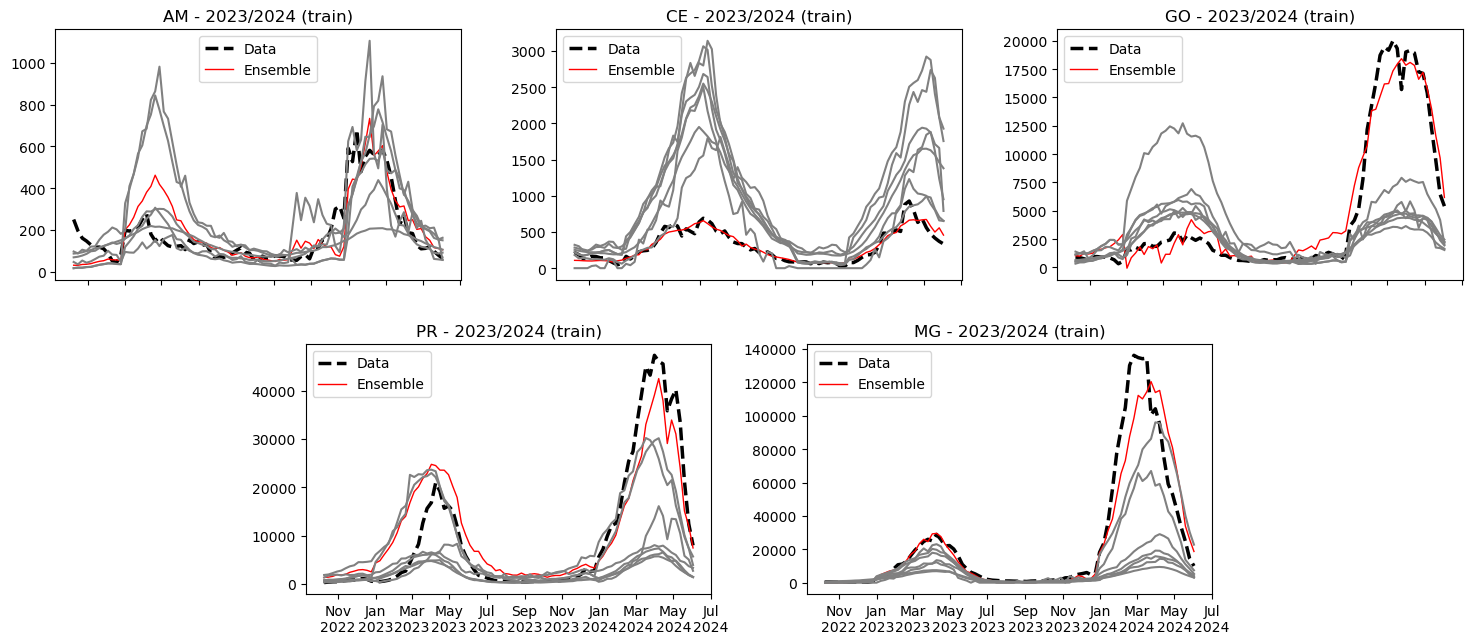

In [7]:
fig = plt.figure(figsize=(15, 7.5))
gs = gridspec.GridSpec(2, 6, figure=fig)
    
# First row with three boxplots
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
    
# Second row with two boxplots
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

i = 0
for state, ax  in zip(['AM', 'CE', 'GO', 'PR', 'MG'],
                      [ax1,ax2,ax3,ax4,ax5]): 

    X1, y1 = get_data_slice(data, state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))
    X2, y2 = get_data_slice(data, state, start_date = Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2024, 23).startdate().strftime('%Y-%m-%d'))

    X = pd.concat([X1, X2])
    y = np.append(y1,y2, axis =0)
    
    estimators = []
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
    
         estimators.append((f'{model_id}', SprintModel(model_id = model_id,
                                                      state = state)))
        
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=MLPRegressor()
    )
    
    stack.fit(X.values, y)
    
    stack_preds = stack.predict(X.values)

    dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2024, 23).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    dates = np.append(dates_23,dates_24, axis =0)

    ax.plot(dates, y, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)
    
    ax.plot(dates, stack_preds, color = 'red', label = 'Ensemble', linewidth = 1)
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
    
        ax.plot(dates, SprintModel(model_id = model_id, state = state).predict(X.values),
               color = 'grey')

    ax.set_title(f'{state} - 2023/2024 (train)')
 
    ax.legend()    

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'

    i = i +1

plt.tight_layout()
# Rotate the date labels for better readability
fig.autofmt_xdate(rotation=0, ha='center')

plt.show()


### Training and evaluating using sampled values from the predictive interval: 

In the cell below, the stacking regressor will be applied using MLP as the final estimator. The stack model is trained using the predictions for 2023 and tested using the predictions for 2024. The performance of the train and test are shown in the figure. The training and testing is done using 100 observations sampled from the models.

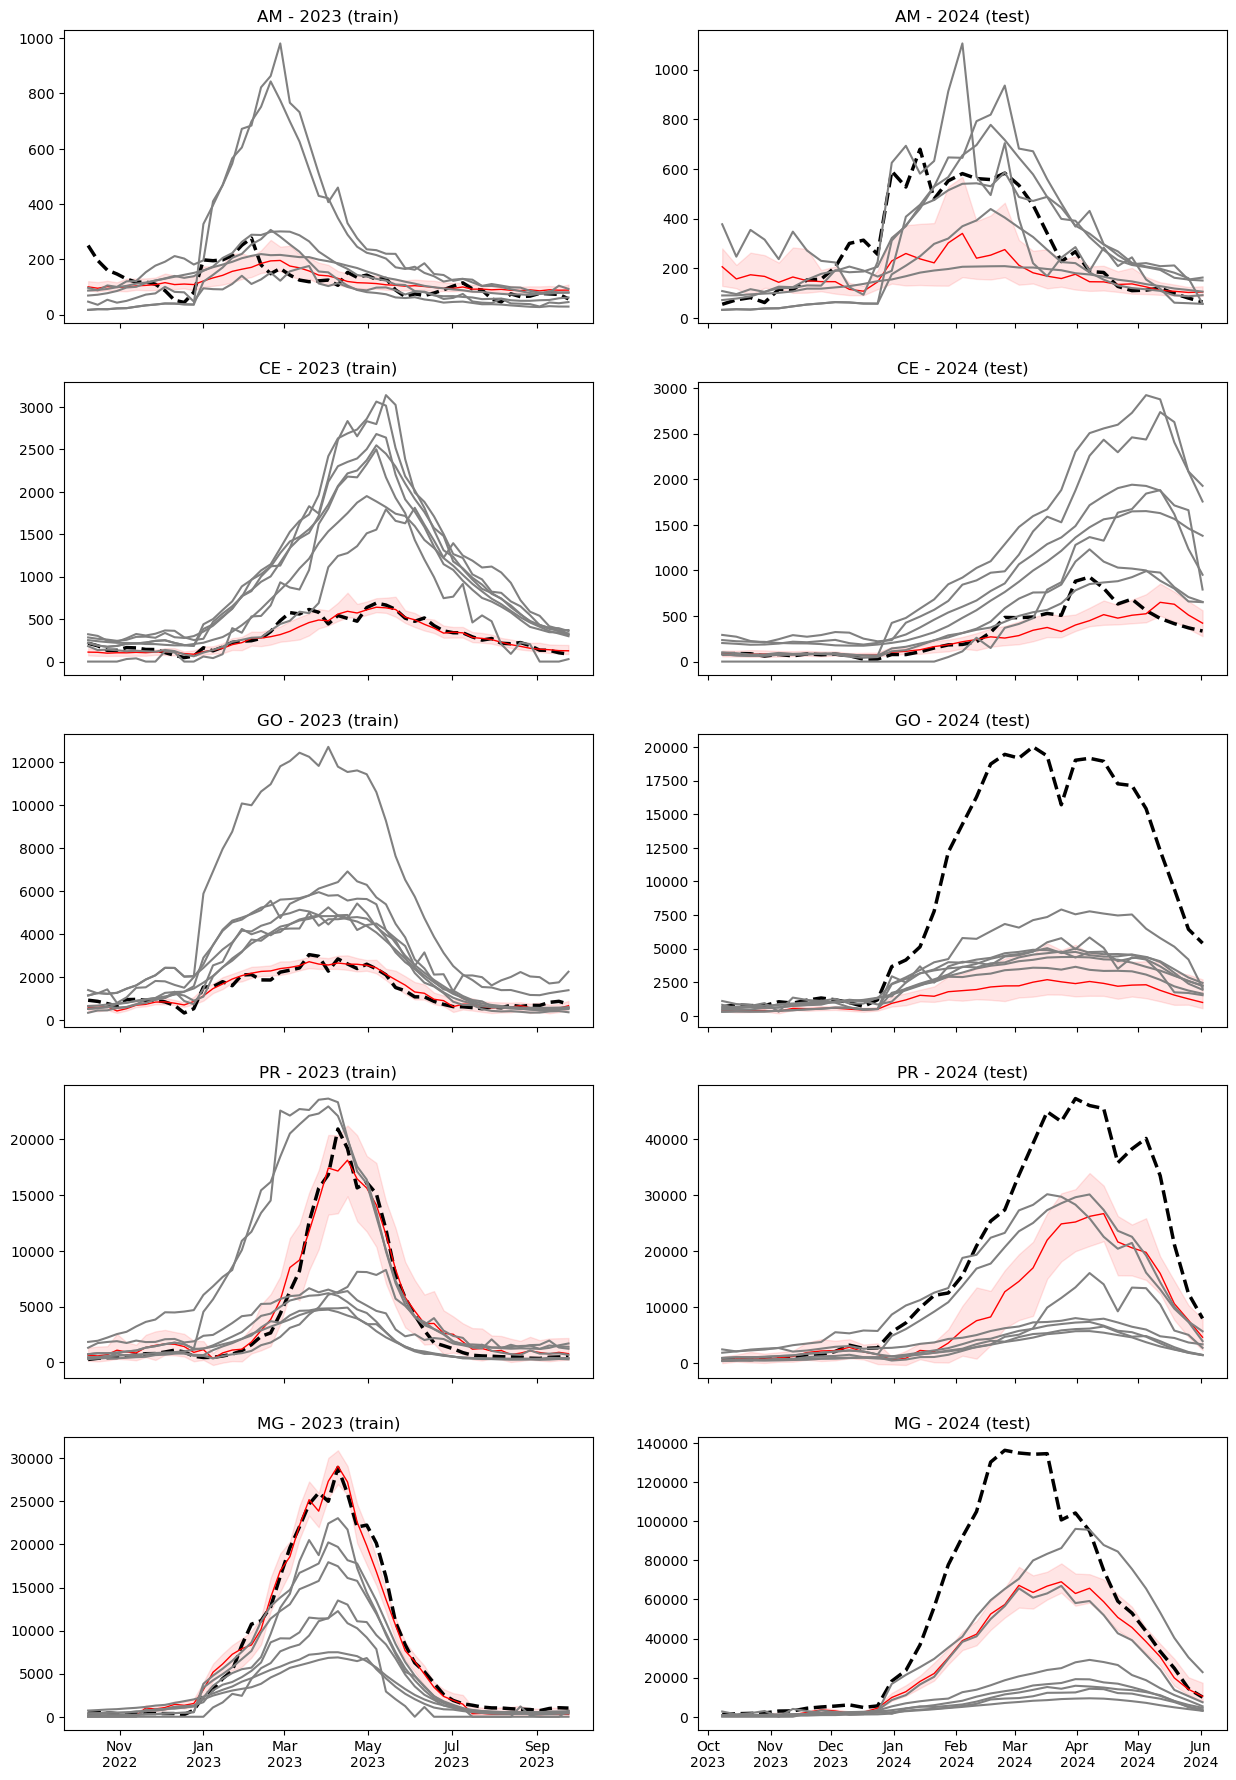

CPU times: user 1min 24s, sys: 1.54 s, total: 1min 26s
Wall time: 1min 29s


In [8]:
%%time
fig, axs  = plt.subplots(5,2, figsize = (15, 25))

ax = axs.ravel()

j = 0
for state in ['AM', 'CE', 'GO', 'PR', 'MG']: 

    list_X = []# pd.concat([X1, X2])
    y = np.array([])
    for i in np.arange(0,100): 
        
        X_, y_ = get_data_slice(data, state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                                  end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))

        list_X.append(X_)

        y = np.append(y,y_, axis =0)
        
    X = pd.concat(list_X)
        
    estimators = []
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
    
         estimators.append((f'{model_id}', SprintModel(model_id = model_id,
                                                      state = state, mean = False)))
           
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=MLPRegressor()
    )
    
    stack.fit(X.values, y)

    stack_preds = np.empty((0, 51))
    
    for i in np.arange(0,100):
        stack_preds_ = stack.predict(X_.values).reshape(1,-1)

        stack_preds = np.append(stack_preds, stack_preds_, axis=0)

    lower = np.percentile(stack_preds, 5, axis =0)
    pred = np.percentile(stack_preds, 50, axis =0)
    upper = np.percentile(stack_preds, 95, axis =0)

    dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    ax[j].plot(dates_23, y_, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)
    
    ax[j].plot(dates_23, pred, color = 'red', label = 'Ensemble', linewidth = 1)

    ax[j].fill_between(dates_23, lower, upper, color = 'red', alpha=0.1)
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
    
        ax[j].plot(dates_23, SprintModel(model_id = model_id, state = state, mean = True).predict(X_.values),
               color = 'grey')

    ax[j].set_title(f'{state} - 2023 (train)')

    
    ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y')) 

    list_X = []
    y = np.array([])
    for i in np.arange(0,100): 
        
        X_, y_ = get_data_slice(data, state, start_date = Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                                  end_date = Week(2024, 23).startdate().strftime('%Y-%m-%d'))

        list_X.append(X_)

        y = np.append(y,y_, axis =0)
        
    X = pd.concat(list_X)
           
    stack_preds = np.empty((0, 35))
    
    for i in np.arange(0,100):
        stack_preds_ = stack.predict(X_.values).reshape(1,-1)

        stack_preds = np.append(stack_preds, stack_preds_, axis=0)

    lower = np.percentile(stack_preds, 5, axis =0)
    pred = np.percentile(stack_preds, 50, axis =0)
    upper = np.percentile(stack_preds, 95, axis =0)

    dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2024, 23).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    ax[j+1].plot(dates_24, y_, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)
    
    ax[j+1].plot(dates_24, pred, color = 'red', label = 'Ensemble', linewidth = 1)

    ax[j+1].fill_between(dates_24, lower, upper, color = 'red', alpha=0.1)
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
    
        ax[j+1].plot(dates_24, SprintModel(model_id = model_id, state = state, mean = True).predict(X_.values),
               color = 'grey')

    ax[j+1].set_title(f'{state} - 2024 (test)')

    
    ax[j+1].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22
    
    j = j+2

# Rotate the date labels for better readability
fig.autofmt_xdate(rotation=0, ha='center')

plt.show()

In [9]:
stack

StackingRegressor(estimators=[('34',
                               SprintModel(mean=False, model_id=34,
                                           state='MG')),
                              ('21',
                               SprintModel(mean=False, model_id=21,
                                           state='MG')),
                              ('22',
                               SprintModel(mean=False, model_id=22,
                                           state='MG')),
                              ('25',
                               SprintModel(mean=False, model_id=25,
                                           state='MG')),
                              ('27',
                               SprintModel(mean=False, model_id=27,
                                           state='MG')),
                              ('28',
                               SprintModel(mean=False, model_id=28,
                                           state='MG')),
                              ('30',
                               SprintModel(mean=False, model_id=30,
                                           state='MG'))],
                  final_estimator=MLPRegressor())

In the cell below, the stacking regressor will be applied using MLP as the final estimator. The stack model is trained using the predictions for 2023 and 2024. The performance of the train data is shown in the figure. The training and prediction are done using 100 observations sampled from the models.

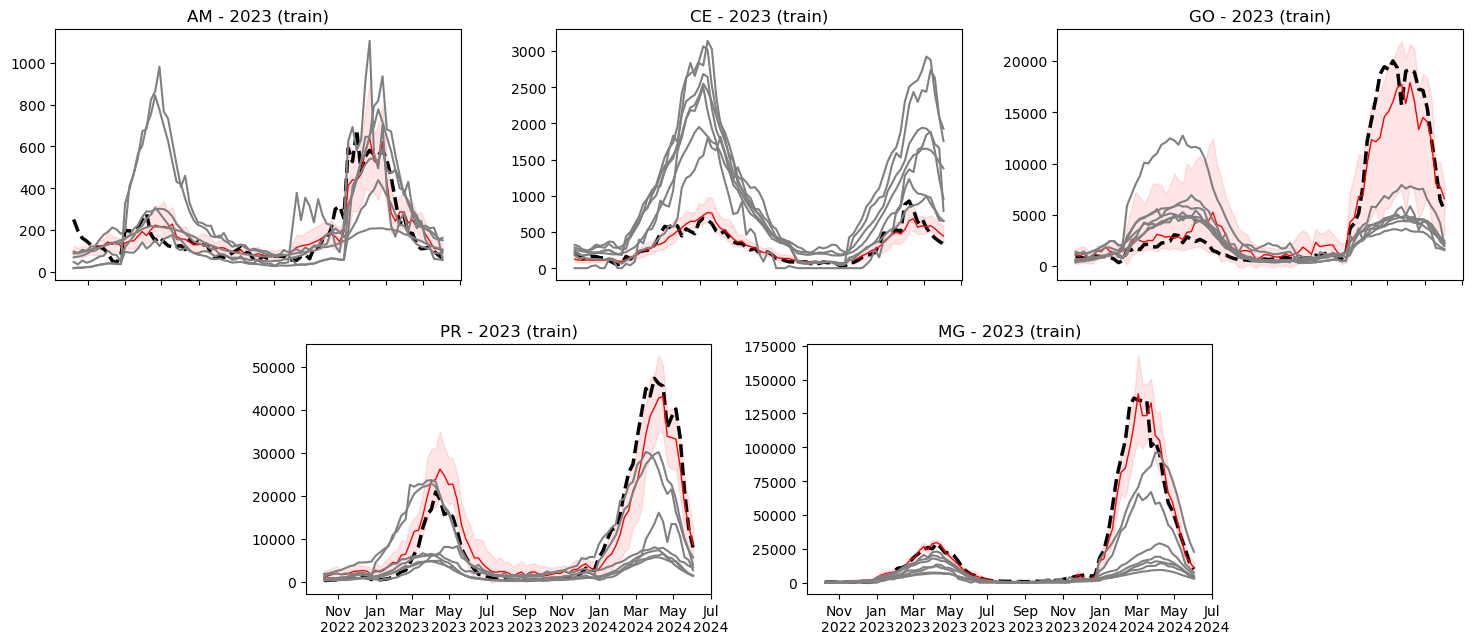

In [10]:
fig = plt.figure(figsize=(15, 7.5))
gs = gridspec.GridSpec(2, 6, figure=fig)
    
# First row with three boxplots
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
    
# Second row with two boxplots
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

i = 0
for state, ax  in zip(['AM', 'CE', 'GO', 'PR', 'MG'],
                      [ax1,ax2,ax3,ax4,ax5]): 

    list_X = []# pd.concat([X1, X2])
    y = np.array([])
    for i in np.arange(0,100):

        X1, y1 = get_data_slice(data, state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))
        
        X2, y2 = get_data_slice(data, state, start_date = Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                                  end_date = Week(2024, 23).startdate().strftime('%Y-%m-%d'))
    
        X_ = pd.concat([X1, X2])
        y_ = np.append(y1,y2, axis =0)
            
        list_X.append(X_)
        
        y = np.append(y,y_, axis =0)
        
    X = pd.concat(list_X)
        
    estimators = []
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
    
         estimators.append((f'{model_id}', SprintModel(model_id = model_id,
                                                      state = state, mean = False)))
           
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=MLPRegressor()
    )
    
    stack.fit(X.values, y)

    stack_preds = np.empty((0, 86))
    
    for i in np.arange(0,100):
        stack_preds_ = stack.predict(X_.values).reshape(1,-1)

        stack_preds = np.append(stack_preds, stack_preds_, axis=0)

    lower = np.percentile(stack_preds, 5, axis =0)
    pred = np.percentile(stack_preds, 50, axis =0)
    upper = np.percentile(stack_preds, 95, axis =0)

    dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2024, 23).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    dates = np.append(dates_23,dates_24, axis =0)
    
    ax.plot(dates, y_, color = 'black', linestyle='--', label = 'Data', linewidth = 2.5)
    
    ax.plot(dates, pred, color = 'red', label = 'Ensemble', linewidth = 1)

    ax.fill_between(dates, lower, upper, color = 'red', alpha=0.1)
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
    
        ax.plot(dates, SprintModel(model_id = model_id, state = state, mean = True).predict(X_.values),
               color = 'grey')

    ax.set_title(f'{state} - 2023 (train)')

    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y')) 
        
plt.tight_layout()
# Rotate the date labels for better readability
fig.autofmt_xdate(rotation=0, ha='center')

plt.show()